## Loading Dataset

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *     # Needed for upper, col and aggregate functions
import pandas as pd


spark = SparkSession.builder \
    .appName("CSV") \
    .getOrCreate()

ev = spark.read.csv('../local_datasets/IEA Global EV Data 2024.csv', inferSchema=True, header=True)

ev.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/14 09:33:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---------+----------+--------------+----+----------+----+--------+----------------+
|   region|  category|     parameter|mode|powertrain|year|    unit|           value|
+---------+----------+--------------+----+----------+----+--------+----------------+
|Australia|Historical|EV stock share|Cars|        EV|2011| percent|3.90000001062E-4|
|Australia|Historical|EV sales share|Cars|        EV|2011| percent|0.00650000013411|
|Australia|Historical|      EV sales|Cars|       BEV|2011|Vehicles|            49.0|
|Australia|Historical|      EV stock|Cars|       BEV|2011|Vehicles|            49.0|
|Australia|Historical|      EV stock|Cars|       BEV|2012|Vehicles|           220.0|
+---------+----------+--------------+----+----------+----+--------+----------------+
only showing top 5 rows



In [2]:
ev.printSchema()

root
 |-- region: string (nullable = true)
 |-- category: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- powertrain: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- unit: string (nullable = true)
 |-- value: double (nullable = true)



***value could be int or float depending on unit*** 

### retrieving sales share and sales share growth

In [3]:
from pyspark.sql.window import Window

aussie_ev_sales = ev.where( (col('region')=='Australia') & (col('category')=='Historical') & (col('parameter')=='EV sales share') & (col('mode')=='Cars') & (col('powertrain')=='EV'))
aussie_ev_sales = aussie_ev_sales.withColumn("prev_year_value", lag("value").over(Window.orderBy("year")))
aussie_ev_sales = aussie_ev_sales.withColumn("share_growth_per_year", round((col("value") / col("prev_year_value"))*100,2) )
aussie_ev_sales.show()

24/06/14 09:33:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/14 09:33:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/14 09:33:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/14 09:33:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/14 09:33:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---------+----------+--------------+----+----------+----+-------+-----------------+-----------------+---------------------+
|   region|  category|     parameter|mode|powertrain|year|   unit|            value|  prev_year_value|share_growth_per_year|
+---------+----------+--------------+----+----------+----+-------+-----------------+-----------------+---------------------+
|Australia|Historical|EV sales share|Cars|        EV|2011|percent| 0.00650000013411|             NULL|                 NULL|
|Australia|Historical|EV sales share|Cars|        EV|2012|percent|0.029999999329448| 0.00650000013411|               461.54|
|Australia|Historical|EV sales share|Cars|        EV|2013|percent|0.034000001847744|0.029999999329448|               113.33|
|Australia|Historical|EV sales share|Cars|        EV|2014|percent|0.159999996423721|0.034000001847744|               470.59|
|Australia|Historical|EV sales share|Cars|        EV|2015|percent|0.200000002980232|0.159999996423721|                125.0|


## World EV sales share

In [4]:
all_ev_sales_shares = ev.where( (col('category')=='Historical') & (col('parameter')=='EV sales share') & (col('mode')=='Cars') & (col('powertrain')=='EV'))

all_ev_sales_shares = all_ev_sales_shares.filter( ~all_ev_sales_shares['region'].isin(['Europe', 'EU27', 'World']) )

all_ev_sales_shares = all_ev_sales_shares.drop('category','parameter', 'mode', 'powertrain', 'unit')

all_ev_sales_shares.show()

+---------+----+-----------------+
|   region|year|            value|
+---------+----+-----------------+
|Australia|2011| 0.00650000013411|
|Australia|2012|0.029999999329448|
|Australia|2013|0.034000001847744|
|Australia|2014|0.159999996423721|
|Australia|2015|0.200000002980232|
|Australia|2016|0.150000005960464|
|Australia|2017|0.259999990463257|
|Australia|2018|0.419999986886978|
|Australia|2019| 1.20000004768372|
|Australia|2020| 1.10000002384186|
|Australia|2021| 2.79999995231628|
|Australia|2022| 5.09999990463257|
|Australia|2023|             12.0|
|  Austria|2013|0.200000002980232|
|  Austria|2014|0.569999992847443|
|  Austria|2015|0.899999976158142|
|  Austria|2016|              1.5|
|  Austria|2017|              2.0|
|  Austria|2018| 2.59999990463257|
|  Austria|2019|              3.5|
+---------+----+-----------------+
only showing top 20 rows



### Aus Shares

In [5]:
aus_ev_shares = all_ev_sales_shares.where( col('region')=='Australia' )

aus_ev_shares = aus_ev_shares.withColumnRenamed("value", "aus_shares")


aus_ev_shares.show()

+---------+----+-----------------+
|   region|year|       aus_shares|
+---------+----+-----------------+
|Australia|2011| 0.00650000013411|
|Australia|2012|0.029999999329448|
|Australia|2013|0.034000001847744|
|Australia|2014|0.159999996423721|
|Australia|2015|0.200000002980232|
|Australia|2016|0.150000005960464|
|Australia|2017|0.259999990463257|
|Australia|2018|0.419999986886978|
|Australia|2019| 1.20000004768372|
|Australia|2020| 1.10000002384186|
|Australia|2021| 2.79999995231628|
|Australia|2022| 5.09999990463257|
|Australia|2023|             12.0|
+---------+----+-----------------+



### Avg shares

In [6]:
avg_shares = all_ev_sales_shares.groupBy('year').agg(mean('value').alias('avg_sales_share')).orderBy('year')

avg_shares.show()

+----+-------------------+
|year|    avg_sales_share|
+----+-------------------+
|2010|0.02634166671325356|
|2011|0.11516518424657447|
|2012| 0.2718206864886051|
|2013| 0.5526753156850644|
|2014| 0.9660250020751844|
|2015|  1.215745460040952|
|2016| 1.4411555670615699|
|2017|  2.093222219331397|
|2018|  3.048377751890156|
|2019|  3.741612236186558|
|2020|  7.878916650700073|
|2021|  12.14036735101622|
|2022|  15.11897961673688|
|2023|  18.81836735168282|
+----+-------------------+



### Top Country Shares (Norway)

In [57]:
top_shares_country_name = all_ev_sales_shares.where(col('year')==2023)\
    .groupby('region')\
        .max('value')\
            .orderBy( col('max(value)').desc() ).first()[0]



top_country_shares = all_ev_sales_shares.where(col('region')==top_shares_country_name).select(all_ev_sales_shares.year,all_ev_sales_shares.value)

top_country_shares = top_country_shares.withColumnRenamed("value", top_shares_country_name)


top_country_shares.show()


+----+-----------------+
|year|           Norway|
+----+-----------------+
|2010|0.280000001192093|
|2011| 1.39999997615814|
|2012| 3.09999990463257|
|2013| 5.80000019073486|
|2014|             15.0|
|2015|             22.0|
|2016|             29.0|
|2017|             39.0|
|2018|             49.0|
|2019|             56.0|
|2020|             75.0|
|2021|             86.0|
|2022|             89.0|
|2023|             93.0|
+----+-----------------+



## World EV Sales per Yer

In [8]:

# retrieve specific rows 
all_ev_sales = ev.where( (col('category')=='Historical') & (col('parameter')=='EV sales') & (col('mode')=='Cars') )
all_ev_sales = all_ev_sales.filter( ~all_ev_sales['region'].isin(['Europe', 'EU27', 'World']) )

# get rid of irrevelant rows
all_ev_sales = all_ev_sales.drop('category','parameter', 'mode', 'powertrain', 'unit')


all_ev_sales = all_ev_sales.groupBy('region', "year").agg(sum("value").alias("sales"))
all_ev_sales = all_ev_sales.orderBy(col("region").asc(), col("year").asc())
all_ev_sales.show()

+---------+----+-------+
|   region|year|  sales|
+---------+----+-------+
|Australia|2011|   49.0|
|Australia|2012|  250.0|
|Australia|2013|  290.0|
|Australia|2014| 1320.0|
|Australia|2015| 1760.0|
|Australia|2016| 1370.0|
|Australia|2017| 2300.0|
|Australia|2018| 3600.0|
|Australia|2019| 9200.0|
|Australia|2020| 6900.0|
|Australia|2021|20444.0|
|Australia|2022|38915.0|
|Australia|2023|98006.0|
|  Austria|2013|  650.0|
|  Austria|2014| 1706.0|
|  Austria|2015| 2804.0|
|  Austria|2016| 5000.0|
|  Austria|2017| 7102.0|
|  Austria|2018| 9107.0|
|  Austria|2019|11519.0|
+---------+----+-------+
only showing top 20 rows



### Average sales of EVs per year

In [9]:
avg_sales = all_ev_sales.groupBy('year').agg(round(mean('sales'),0).alias('avg_sales')).orderBy('year')

avg_sales.show()

+----+---------+
|year|avg_sales|
+----+---------+
|2010|    366.0|
|2011|   1806.0|
|2012|   4073.0|
|2013|   6413.0|
|2014|  10236.0|
|2015|  12584.0|
|2016|  16840.0|
|2017|  25994.0|
|2018|  43971.0|
|2019|  43309.0|
|2020|  60825.0|
|2021| 133455.0|
|2022| 207420.0|
|2023| 277396.0|
+----+---------+



### Aussie Sales data

In [10]:
aus_sales = all_ev_sales.where( col('region')=='Australia' )\
    .select(all_ev_sales.year, all_ev_sales.sales)

aus_sales = aus_sales.withColumnRenamed("sales", "aus_sales")


aus_sales.show()

+----+---------+
|year|aus_sales|
+----+---------+
|2011|     49.0|
|2012|    250.0|
|2013|    290.0|
|2014|   1320.0|
|2015|   1760.0|
|2016|   1370.0|
|2017|   2300.0|
|2018|   3600.0|
|2019|   9200.0|
|2020|   6900.0|
|2021|  20444.0|
|2022|  38915.0|
|2023|  98006.0|
+----+---------+



### Top Country sales data (China)

In [59]:
# country with highest sales last year
top_sales_country_name = all_ev_sales.where(col('year')==2023)\
    .groupby('region')\
        .max('sales')\
            .orderBy( col('max(sales)').desc() ).first()[0]

top_country_sales = all_ev_sales.where(col('region')==top_sales_country_name).select(all_ev_sales.year,all_ev_sales.sales)

top_country_sales = top_country_sales.withColumnRenamed("sales", top_sales_country_name)


top_country_sales.show()


+----+---------+
|year|    China|
+----+---------+
|2010|   1440.0|
|2011|   5120.0|
|2012|   9860.0|
|2013|  15730.0|
|2014|  73000.0|
|2015| 211000.0|
|2016| 339000.0|
|2017| 580000.0|
|2018|1090000.0|
|2019|1060000.0|
|2020|1140000.0|
|2021|3250019.0|
|2022|5900240.0|
|2023|8100520.0|
+----+---------+



## Charging points

In [12]:
# retrieve specific rows 
all_ev_charge_points = ev.where( (col('category')=='Historical') & (col('parameter')=='EV charging points') )
all_ev_charge_points = all_ev_charge_points.filter( ~all_ev_charge_points['region'].isin(['Europe', 'EU27', 'World']) )

# get rid of irrevelant rows (aka rows that aren't countries)
all_ev_charge_points = all_ev_charge_points.drop('category','parameter', 'mode', 'unit')



all_ev_charge_points = all_ev_charge_points.orderBy(col("region").asc(), col("year").asc())
all_ev_charge_points.show()

+---------+--------------------+----+-----------------+
|   region|          powertrain|year|            value|
+---------+--------------------+----+-----------------+
|Australia|Publicly availabl...|2017|             40.0|
|Australia|Publicly availabl...|2017|            440.0|
|Australia|Publicly availabl...|2018|             61.0|
|Australia|Publicly availabl...|2018|            670.0|
|Australia|Publicly availabl...|2019|           1700.0|
|Australia|Publicly availabl...|2020|           2300.0|
|Australia|Publicly availabl...|2021|            320.0|
|Australia|Publicly availabl...|2021|           2000.0|
|Australia|Publicly availabl...|2022|            470.0|
|Australia|Publicly availabl...|2022|           2100.0|
|Australia|Publicly availabl...|2023|            660.0|
|Australia|Publicly availabl...|2023|           2100.0|
|  Austria|Publicly availabl...|2011|0.100000001490116|
|  Austria|Publicly availabl...|2011|0.100000001490116|
|  Austria|Publicly availabl...|2012|0.100000001

### Aus charging points per yer

In [13]:
aus_chargers = all_ev_charge_points.where( col('region')=='Australia' ).orderBy('year')

aus_chargers = aus_chargers.groupBy('year').agg(round(sum('value'),2).alias('aus_chargers')).orderBy('year')

aus_chargers.show()

+----+------------+
|year|aus_chargers|
+----+------------+
|2017|       480.0|
|2018|       731.0|
|2019|      1700.0|
|2020|      2300.0|
|2021|      2320.0|
|2022|      2570.0|
|2023|      2760.0|
+----+------------+



### Avg amount of charging points (fast and slow) per yer

In [14]:
avg_ev_charge = all_ev_charge_points.groupBy('region','year')\
    .agg(round(sum('value'),2).alias('sum_chargers'))\
        .orderBy('region','year')\
            .groupBy('year').agg(round(mean('sum_chargers'),0).alias('avg_chargers')).orderBy('year')


avg_ev_charge.show()

+----+------------+
|year|avg_chargers|
+----+------------+
|2010|       998.0|
|2011|      1353.0|
|2012|      2006.0|
|2013|      2210.0|
|2014|      4450.0|
|2015|      7160.0|
|2016|     11443.0|
|2017|     13606.0|
|2018|     16647.0|
|2019|     26913.0|
|2020|     37959.0|
|2021|     53716.0|
|2022|     81050.0|
|2023|    117228.0|
+----+------------+



## Sales per EV type

In [15]:
all_ev_type_sales = ev.where( (col('category')=='Historical') & (col('parameter')=='EV sales') & (col('mode')=='Cars') )

# get rid of irrevelant rows
all_ev_type_sales = all_ev_type_sales.drop('category','parameter', 'mode', 'unit')
all_ev_type_sales = all_ev_type_sales.withColumnRenamed("value", "sales")


all_ev_type_sales.show()

+---------+----------+----+------+
|   region|powertrain|year| sales|
+---------+----------+----+------+
|Australia|       BEV|2011|  49.0|
|Australia|       BEV|2012| 170.0|
|Australia|      PHEV|2012|  80.0|
|Australia|      PHEV|2013| 100.0|
|Australia|       BEV|2013| 190.0|
|Australia|       BEV|2014| 370.0|
|Australia|      PHEV|2014| 950.0|
|Australia|      PHEV|2015|1000.0|
|Australia|       BEV|2015| 760.0|
|Australia|       BEV|2016| 670.0|
|Australia|      PHEV|2016| 700.0|
|Australia|      PHEV|2017|1100.0|
|Australia|       BEV|2017|1200.0|
|Australia|       BEV|2018|1800.0|
|Australia|      PHEV|2018|1800.0|
|Australia|      PHEV|2019|2900.0|
|Australia|       BEV|2019|6300.0|
|Australia|       BEV|2020|5200.0|
|Australia|      PHEV|2020|1700.0|
|Australia|      PHEV|2021|3400.0|
+---------+----------+----+------+
only showing top 20 rows



### Avg sales per type

In [16]:
# round avg_sale to nearest int as partial sale cannot happen
avg_type_sales = all_ev_type_sales.groupBy('powertrain', 'year').agg(round(mean('sales'),0).alias('avg_sales')).orderBy('powertrain','year')


avg_type_sales = avg_type_sales.withColumn("avg_sales", col("avg_sales").cast("int"))


avg_type_sales.show()

+----------+----+---------+
|powertrain|year|avg_sales|
+----------+----+---------+
|       BEV|2010|      775|
|       BEV|2011|     3260|
|       BEV|2012|     4600|
|       BEV|2013|     8177|
|       BEV|2014|    14002|
|       BEV|2015|    17026|
|       BEV|2016|    22594|
|       BEV|2017|    36260|
|       BEV|2018|    63836|
|       BEV|2019|    70398|
|       BEV|2020|   102115|
|       BEV|2021|   219713|
|       BEV|2022|   334466|
|       BEV|2023|   435583|
|      FCEV|2010|       17|
|      FCEV|2011|       38|
|      FCEV|2012|       24|
|      FCEV|2013|       22|
|      FCEV|2014|       21|
|      FCEV|2015|      103|
+----------+----+---------+
only showing top 20 rows



### Aus sales per EV type

In [17]:
aus_type_sales = all_ev_type_sales.where(col('region')=='Australia').orderBy('powertrain','year')


aus_type_sales = aus_type_sales.withColumnRenamed('sales', 'aus_sales')
aus_type_sales = aus_type_sales.withColumn("aus_sales", col("aus_sales").cast("int")).select('powertrain', 'year', 'aus_sales')

aus_type_sales.show()

+----------+----+---------+
|powertrain|year|aus_sales|
+----------+----+---------+
|       BEV|2011|       49|
|       BEV|2012|      170|
|       BEV|2013|      190|
|       BEV|2014|      370|
|       BEV|2015|      760|
|       BEV|2016|      670|
|       BEV|2017|     1200|
|       BEV|2018|     1800|
|       BEV|2019|     6300|
|       BEV|2020|     5200|
|       BEV|2021|    17000|
|       BEV|2022|    33000|
|       BEV|2023|    87000|
|      FCEV|2021|       44|
|      FCEV|2022|       15|
|      FCEV|2023|        6|
|      PHEV|2012|       80|
|      PHEV|2013|      100|
|      PHEV|2014|      950|
|      PHEV|2015|     1000|
+----------+----+---------+
only showing top 20 rows



## Combine columns

### Sales Share: Aus vs. Avg vs. Top Country

In [58]:
#a.join(b, ['id'], how='full').show()

sales_shr_comp = aus_ev_shares.join(avg_shares, ['year'], how='full')\
    .select('year', aus_ev_shares.aus_shares, avg_shares.avg_sales_share)\
    .orderBy('year')
    

sales_shr_comp = sales_shr_comp.join(top_country_shares, ['year'], how='full')\
    .select('year', top_shares_country_name, sales_shr_comp.aus_shares, sales_shr_comp.avg_sales_share)\
    .orderBy('year')

sales_shr_comp.show()

+----+-----------------+-----------------+-------------------+
|year|           Norway|       aus_shares|    avg_sales_share|
+----+-----------------+-----------------+-------------------+
|2010|0.280000001192093|             NULL|0.02634166671325356|
|2011| 1.39999997615814| 0.00650000013411|0.11516518424657447|
|2012| 3.09999990463257|0.029999999329448| 0.2718206864886051|
|2013| 5.80000019073486|0.034000001847744| 0.5526753156850644|
|2014|             15.0|0.159999996423721| 0.9660250020751844|
|2015|             22.0|0.200000002980232|  1.215745460040952|
|2016|             29.0|0.150000005960464| 1.4411555670615699|
|2017|             39.0|0.259999990463257|  2.093222219331397|
|2018|             49.0|0.419999986886978|  3.048377751890156|
|2019|             56.0| 1.20000004768372|  3.741612236186558|
|2020|             75.0| 1.10000002384186|  7.878916650700073|
|2021|             86.0| 2.79999995231628|  12.14036735101622|
|2022|             89.0| 5.09999990463257|  15.11897961

### Sales: Aus vs. Avg vs. Top Country

In [60]:
sales_comp = aus_sales.join(avg_sales, ['year'], how='full')\
    .select('year', aus_sales.aus_sales, avg_sales.avg_sales)\
        .orderBy('year')

sales_comp = sales_comp.join(top_country_sales, ['year'], how='full')\
    .select('year', top_sales_country_name, sales_comp.aus_sales, sales_comp.avg_sales)\
    .orderBy('year')


#sales_comp = sales_comp.withColumn("top_country_sales", col("top_country_sales").cast("int"))\
    #.withColumn("aus_sales", col("aus_sales").cast("int"))\
    #.withColumn("avg_sales", col("avg_sales").cast("int"))
                                   


sales_comp.show()

+----+---------+---------+---------+
|year|    China|aus_sales|avg_sales|
+----+---------+---------+---------+
|2010|   1440.0|     NULL|    366.0|
|2011|   5120.0|     49.0|   1806.0|
|2012|   9860.0|    250.0|   4073.0|
|2013|  15730.0|    290.0|   6413.0|
|2014|  73000.0|   1320.0|  10236.0|
|2015| 211000.0|   1760.0|  12584.0|
|2016| 339000.0|   1370.0|  16840.0|
|2017| 580000.0|   2300.0|  25994.0|
|2018|1090000.0|   3600.0|  43971.0|
|2019|1060000.0|   9200.0|  43309.0|
|2020|1140000.0|   6900.0|  60825.0|
|2021|3250019.0|  20444.0| 133455.0|
|2022|5900240.0|  38915.0| 207420.0|
|2023|8100520.0|  98006.0| 277396.0|
+----+---------+---------+---------+



In [72]:
aus_avg_full_comp = sales_shr_comp.join(sales_comp, ['year'], how='full')\
    .select('year', sales_comp.aus_sales, sales_comp.avg_sales, top_sales_country_name, sales_shr_comp.aus_shares, sales_shr_comp.avg_sales_share, top_shares_country_name)

aus_avg_full_comp = aus_avg_full_comp.withColumn("aus_sales", col("aus_sales").cast("int")).withColumn("avg_sales", col("avg_sales").cast("int")).withColumn(top_sales_country_name, col(top_sales_country_name).cast("int"))

aus_avg_full_comp = aus_avg_full_comp.withColumnRenamed('avg_sales_share', 'Average shares')
aus_avg_full_comp = aus_avg_full_comp.withColumnRenamed('avg_sales', 'Average sales')

aus_avg_full_comp = aus_avg_full_comp.withColumnRenamed('aus_shares', 'Australia shares')
aus_avg_full_comp = aus_avg_full_comp.withColumnRenamed('aus_sales', 'Australia sales')

aus_avg_full_comp = aus_avg_full_comp.withColumnRenamed('China', 'China sales')

aus_avg_full_comp = aus_avg_full_comp.withColumnRenamed('Norway', 'Norway shares')







aus_avg_full_comp.show()

+----+---------------+-------------+-----------+-----------------+-------------------+-----------------+
|year|Australia sales|Average sales|China sales| Australia shares|     Average shares|    Norway shares|
+----+---------------+-------------+-----------+-----------------+-------------------+-----------------+
|2010|           NULL|          366|       1440|             NULL|0.02634166671325356|0.280000001192093|
|2011|             49|         1806|       5120| 0.00650000013411|0.11516518424657447| 1.39999997615814|
|2012|            250|         4073|       9860|0.029999999329448| 0.2718206864886051| 3.09999990463257|
|2013|            290|         6413|      15730|0.034000001847744| 0.5526753156850644| 5.80000019073486|
|2014|           1320|        10236|      73000|0.159999996423721| 0.9660250020751844|             15.0|
|2015|           1760|        12584|     211000|0.200000002980232|  1.215745460040952|             22.0|
|2016|           1370|        16840|     339000|0.15000

In [73]:
aaa = aus_avg_full_comp.toPandas()
aaa.to_csv('australia_ev_comp.csv')

### Chargers: Aus vs. Avg

In [20]:
charge_comp = aus_chargers.join(avg_ev_charge, ['year'], how='full')\
    .select('year', aus_chargers.aus_chargers, avg_ev_charge.avg_chargers)\
        .orderBy('year')

charge_comp = charge_comp.withColumn("aus_chargers", col("aus_chargers").cast("int")).withColumn("avg_chargers", col("avg_chargers").cast("int"))

charge_comp.show()


+----+------------+------------+
|year|aus_chargers|avg_chargers|
+----+------------+------------+
|2010|        NULL|         998|
|2011|        NULL|        1353|
|2012|        NULL|        2006|
|2013|        NULL|        2210|
|2014|        NULL|        4450|
|2015|        NULL|        7160|
|2016|        NULL|       11443|
|2017|         480|       13606|
|2018|         731|       16647|
|2019|        1700|       26913|
|2020|        2300|       37959|
|2021|        2320|       53716|
|2022|        2570|       81050|
|2023|        2760|      117228|
+----+------------+------------+



### EV Type Sales (BEV,PHEC, FCEV): Aus vs. Avg

In [21]:
type_sales_comp = aus_type_sales.join(avg_type_sales, ['year','powertrain'], how='full' )\
    .select('year', 'powertrain', aus_type_sales.aus_sales, avg_type_sales.avg_sales)\
    .orderBy('powertrain', 'year')


type_sales_comp = type_sales_comp.fillna(0)

type_sales_comp.show()

type_sales_comp.toPandas().to_csv('types_sales.csv')

+----+----------+---------+---------+
|year|powertrain|aus_sales|avg_sales|
+----+----------+---------+---------+
|2010|       BEV|        0|      775|
|2011|       BEV|       49|     3260|
|2012|       BEV|      170|     4600|
|2013|       BEV|      190|     8177|
|2014|       BEV|      370|    14002|
|2015|       BEV|      760|    17026|
|2016|       BEV|      670|    22594|
|2017|       BEV|     1200|    36260|
|2018|       BEV|     1800|    63836|
|2019|       BEV|     6300|    70398|
|2020|       BEV|     5200|   102115|
|2021|       BEV|    17000|   219713|
|2022|       BEV|    33000|   334466|
|2023|       BEV|    87000|   435583|
|2010|      FCEV|        0|       17|
|2011|      FCEV|        0|       38|
|2012|      FCEV|        0|       24|
|2013|      FCEV|        0|       22|
|2014|      FCEV|        0|       21|
|2015|      FCEV|        0|      103|
+----+----------+---------+---------+
only showing top 20 rows



### Top 5 countries with the highest sales shares in the current year
- show good trends of growth 
- also countries to look at for policies

In [22]:

top_shares_countries = all_ev_sales_shares.where(col('year')==2023)\
    .groupby('region')\
        .max('value')\
        .orderBy( col('max(value)').desc() ).limit(5)




# get top countries names
top_countries_shares_list = [row["region"] for row in top_shares_countries.collect()]

# get top countries rows
top_countries_shares = all_ev_sales_shares.filter(col('region').isin(top_countries_shares_list))

# change column names to match
top_countries_shares = top_countries_shares.withColumnRenamed("value", "sales_share")
aus_shares = aus_ev_shares.withColumnRenamed("aus_shares", "sales_share")

# add aus rows to df
sales_share_comparison = top_countries_shares.union(aus_shares)

updated_avg_shares = avg_shares.withColumn("region", lit('Average'))
updated_avg_shares = updated_avg_shares.withColumnRenamed("avg_sales_share", "sales_share").select('region','year','sales_share')

sales_share_comparison = sales_share_comparison.union(updated_avg_shares) 


sales_share_comparison.show()


+-------+----+-----------------+
| region|year|      sales_share|
+-------+----+-----------------+
|Denmark|2011|             0.25|
|Denmark|2012| 0.28999999165535|
|Denmark|2013|0.280000001192093|
|Denmark|2014|0.899999976158142|
|Denmark|2015| 2.29999995231628|
|Denmark|2016|0.850000023841858|
|Denmark|2017|0.600000023841858|
|Denmark|2018| 2.09999990463257|
|Denmark|2019| 4.19999980926514|
|Denmark|2020|             16.0|
|Denmark|2021|             35.0|
|Denmark|2022|             39.0|
|Denmark|2023|             46.0|
|Finland|2011|0.025000000372529|
|Finland|2012|0.170000001788139|
|Finland|2013|0.209999993443489|
|Finland|2014|0.409999996423721|
|Finland|2015|0.600000023841858|
|Finland|2016| 1.20000004768372|
|Finland|2017| 2.59999990463257|
+-------+----+-----------------+
only showing top 20 rows



### Charging points against sales and sales shares

In [23]:
charge_vs_sales = avg_ev_charge.join(avg_sales, avg_ev_charge.year == avg_sales.year)\
    .select(avg_ev_charge.year, avg_ev_charge.avg_chargers, avg_sales.avg_sales)\
    .orderBy('year')

charge_vs_sales_vs_shares = charge_vs_sales.join(avg_shares, charge_vs_sales.year == avg_shares.year)\
    .select(charge_vs_sales.year, charge_vs_sales.avg_chargers, charge_vs_sales.avg_sales, avg_shares.avg_sales_share)\
    .orderBy('year')




charge_vs_sales_vs_shares.show()

+----+------------+---------+-------------------+
|year|avg_chargers|avg_sales|    avg_sales_share|
+----+------------+---------+-------------------+
|2010|       998.0|    366.0|0.02634166671325356|
|2011|      1353.0|   1806.0|0.11516518424657447|
|2012|      2006.0|   4073.0| 0.2718206864886051|
|2013|      2210.0|   6413.0| 0.5526753156850644|
|2014|      4450.0|  10236.0| 0.9660250020751844|
|2015|      7160.0|  12584.0|  1.215745460040952|
|2016|     11443.0|  16840.0| 1.4411555670615699|
|2017|     13606.0|  25994.0|  2.093222219331397|
|2018|     16647.0|  43971.0|  3.048377751890156|
|2019|     26913.0|  43309.0|  3.741612236186558|
|2020|     37959.0|  60825.0|  7.878916650700073|
|2021|     53716.0| 133455.0|  12.14036735101622|
|2022|     81050.0| 207420.0|  15.11897961673688|
|2023|    117228.0| 277396.0|  18.81836735168282|
+----+------------+---------+-------------------+



## Plots

### Sales Share

#### Aussie sales share over time

24/06/14 09:33:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/14 09:33:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/14 09:33:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/14 09:33:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/14 09:33:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


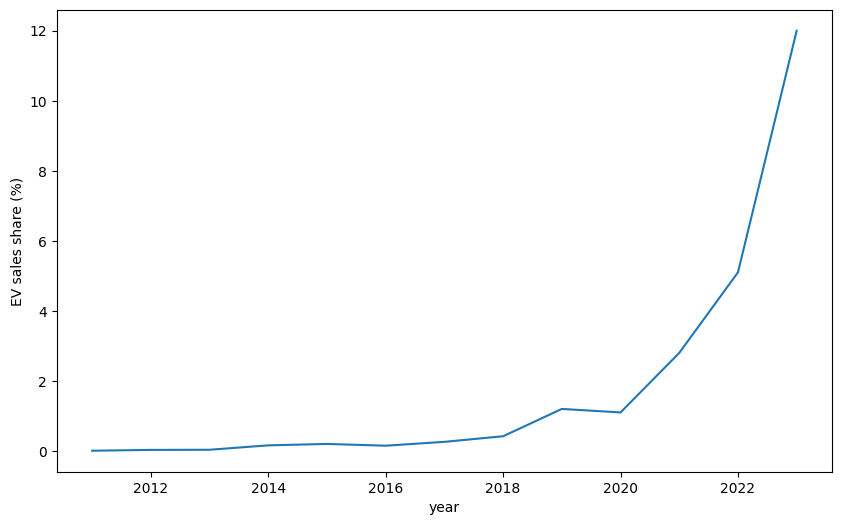

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns



pandas_df = aussie_ev_sales.toPandas()

pandas_df = pandas_df[['year', 'value', 'share_growth_per_year']]
pandas_df

plt.figure(figsize=(10, 6))
plt.plot(pandas_df["year"], pandas_df["value"])
plt.xlabel("year")
plt.ylabel("EV sales share (%)")
plt.show()

### aussie sales share growth over time

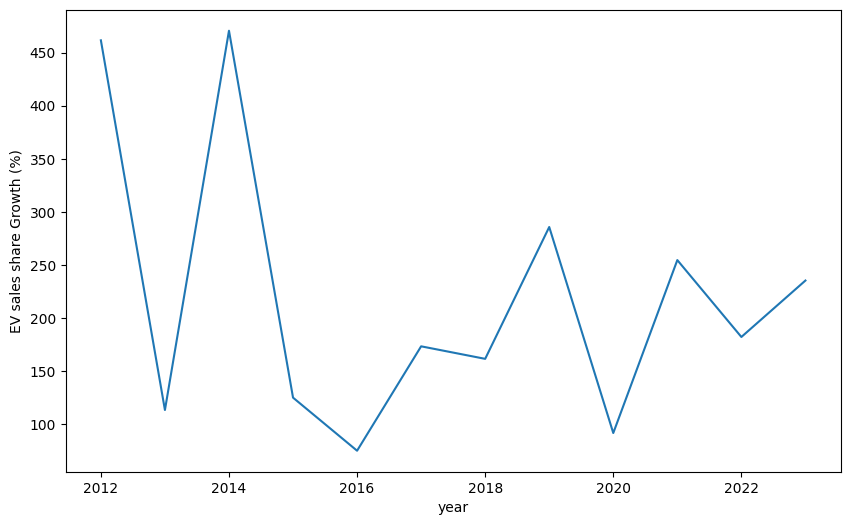

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(pandas_df["year"], pandas_df["share_growth_per_year"])
plt.xlabel("year")
plt.ylabel("EV sales share Growth (%)")
plt.show()

***Don't think this graph is really showing anything***
- shows a few pits where australian EV adoption did not grow (2016, 2010) 
    - maybe see if theres a reason

#### Correlation between number of chargers and EV sales share

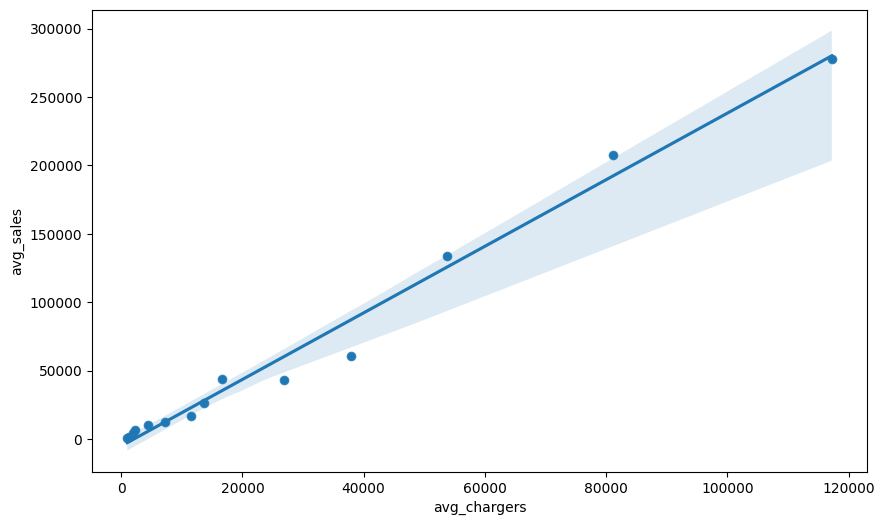

In [26]:
pd_charge_vs_sales_vs_shares = charge_vs_sales_vs_shares.toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_chargers', y='avg_sales', data=pd_charge_vs_sales_vs_shares)
sns.regplot(x='avg_chargers', y='avg_sales', data=pd_charge_vs_sales_vs_shares)

plt.show()


#### Correlation between number of chargers and EV sales (Avg)

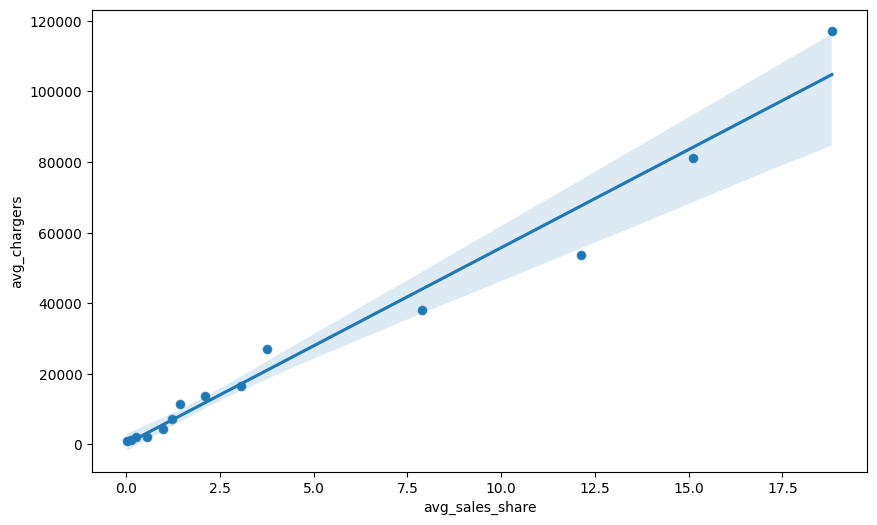

In [27]:
pd_charge_vs_sales_vs_shares = charge_vs_sales_vs_shares.toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(y='avg_chargers', x='avg_sales_share', data=pd_charge_vs_sales_vs_shares)
sns.regplot(y='avg_chargers', x='avg_sales_share', data=pd_charge_vs_sales_vs_shares)
plt.show()


There is a relation between EV adoption rate and number of chargers

#### Top 5 countries and Aus Sales Shares over time

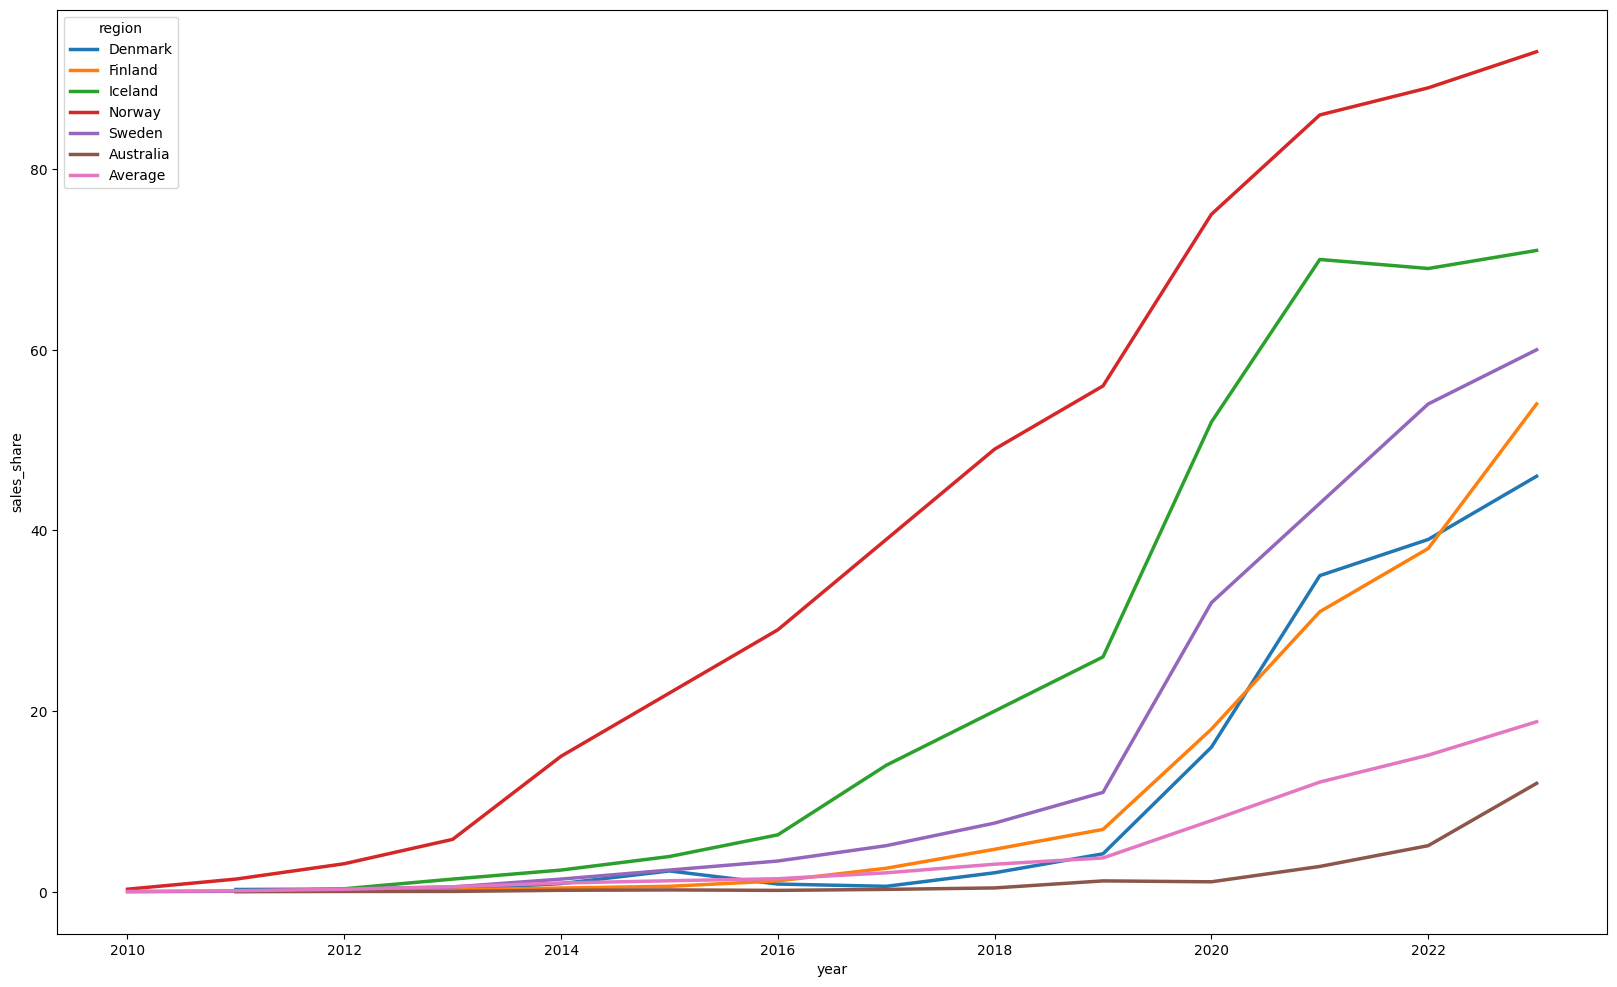

In [28]:
pd_sales_share_comparison =  sales_share_comparison.toPandas()

plt.figure(figsize=(20, 12))
sns.lineplot(data=pd_sales_share_comparison, x='year', y='sales_share', hue='region', linewidth=2.5)
plt.show()

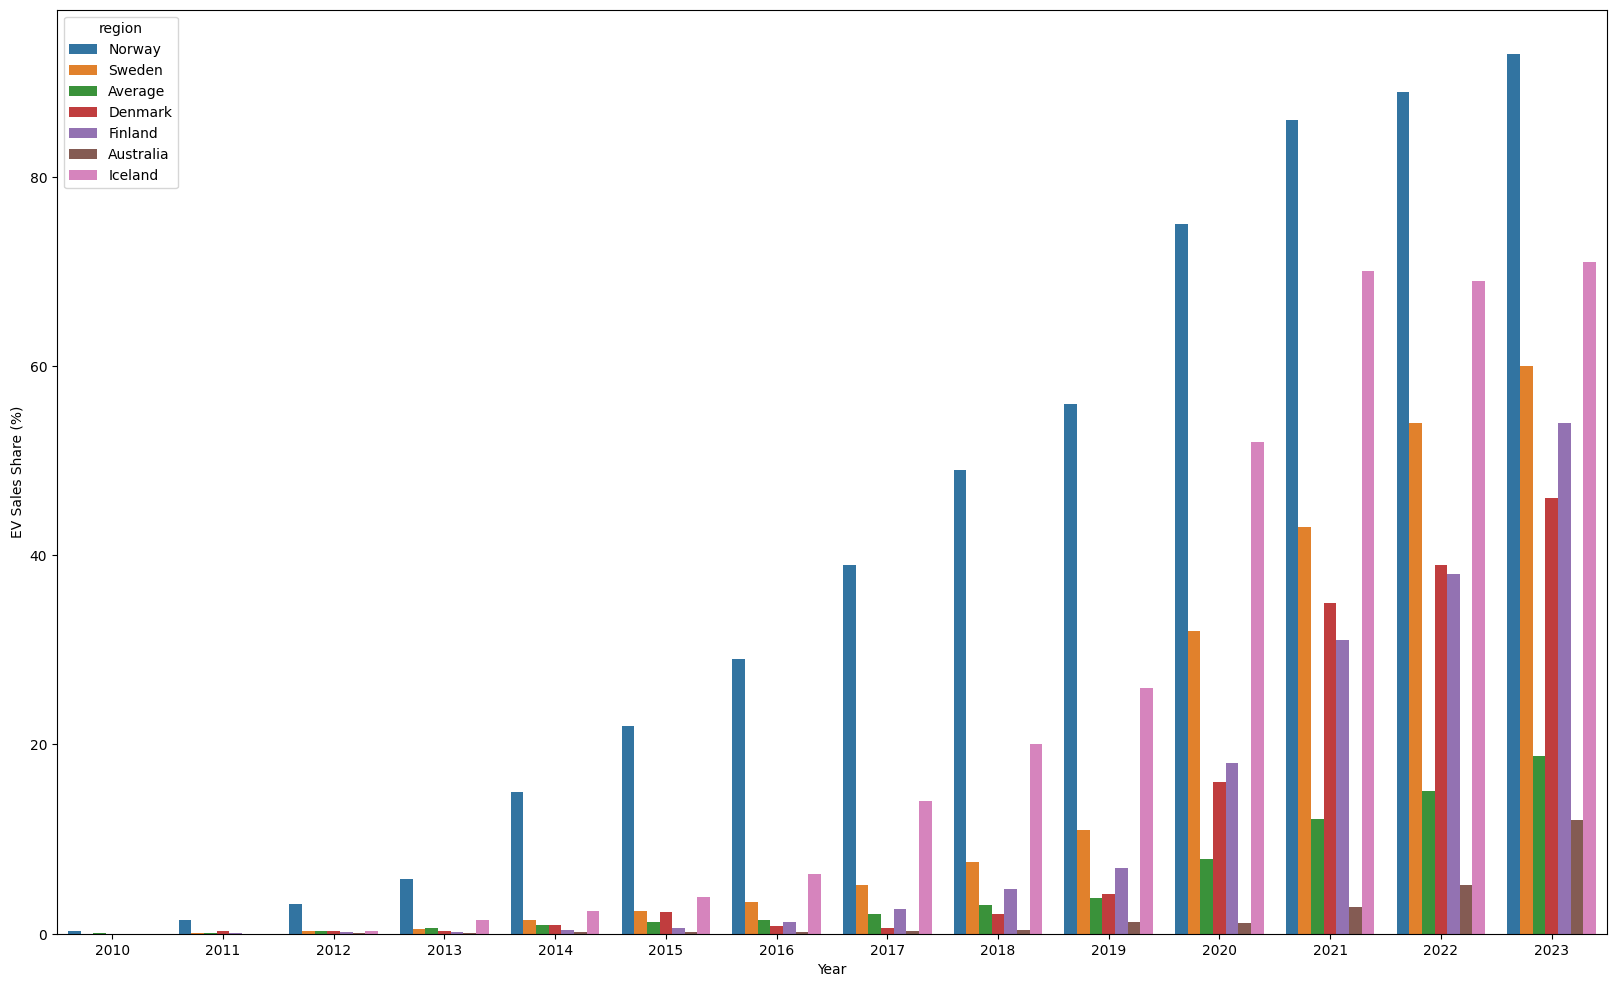

In [29]:
pd_sales_share_comparison =  sales_share_comparison.toPandas()

plt.figure(figsize=(20, 12))
sns.barplot(data=pd_sales_share_comparison, x='year', y='sales_share', hue='region', linewidth=2.5)
plt.xlabel('Year')
plt.ylabel('EV Sales Share (%)')
plt.show()

Australia has only recently increased in EV adoption (since 2020)

### Sales

### Aus vs. Avg sales over time

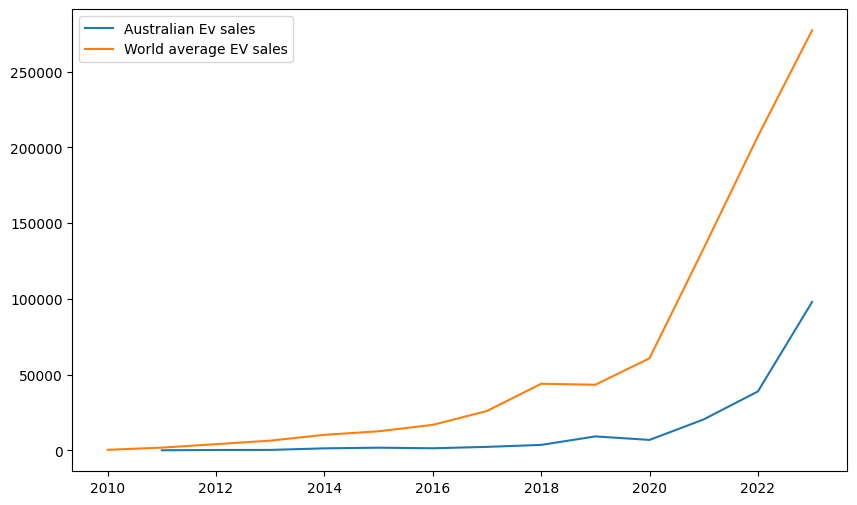

In [30]:
pd_sales_comp = sales_comp.toPandas()

pd_sales_comp
plt.figure(figsize=(10, 6))
plt.plot(pd_sales_comp["year"], pd_sales_comp["aus_sales"], label='Australian Ev sales')
plt.plot(pd_sales_comp["year"], pd_sales_comp["avg_sales"], label='World average EV sales')


# makes other lines unreadable

#plt.plot(pd_sales_comp["year"], pd_sales_comp["top_country_sales"], label='Top Country sales')
plt.legend()


Aus following same sales trend, just at a low quantity

#### Top Country sales (China) 

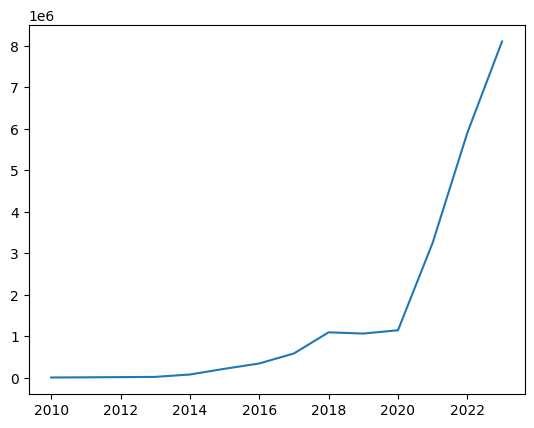

In [31]:
plt.plot(pd_sales_comp["year"], pd_sales_comp["top_country_sales"], label='Top Country sales')


other results cannot be see when add to graph above

### Type Sales

#### Aus Types Sales

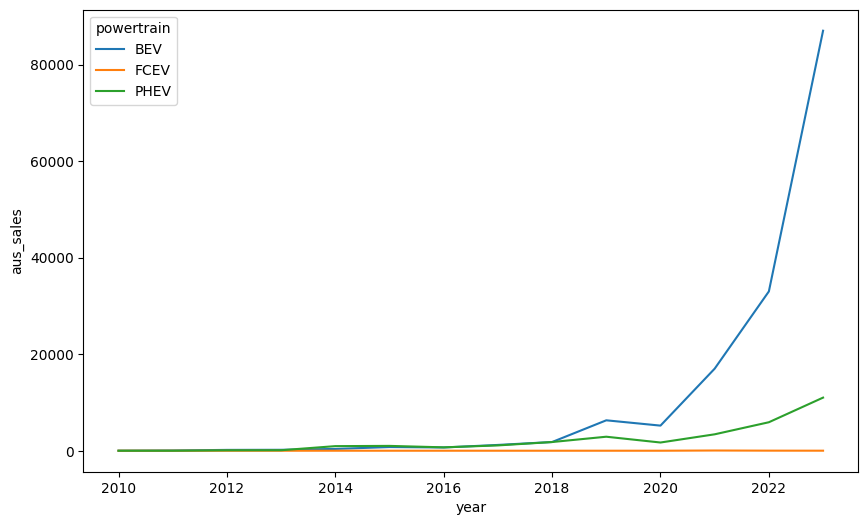

In [32]:
import seaborn as sns


pd_type_sales_comp = type_sales_comp.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=pd_type_sales_comp, x='year', y='aus_sales', hue='powertrain')
plt.show()


- Australia focuses on selling BEV (battery electric vehicle) cars
    - seeing stock may see if this is related to stock levels or lack of interest in the other EV car types

#### Avg Type Sales

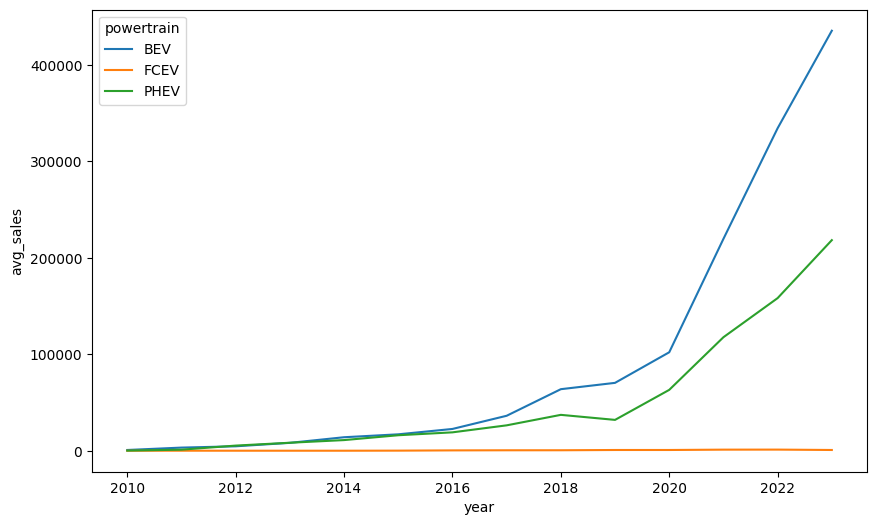

In [33]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=pd_type_sales_comp, x='year', y='avg_sales', hue='powertrain')
plt.show()

#### Aus vs. Avg BEV (Battery Electric vehicles) Sales

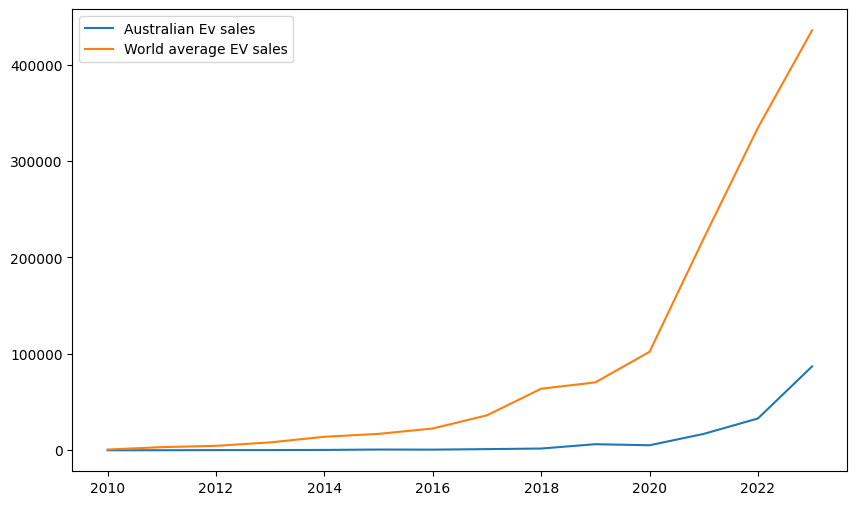

In [34]:
bev_sales = pd_type_sales_comp[pd_type_sales_comp['powertrain']=='BEV']

plt.figure(figsize=(10, 6))
plt.plot(bev_sales["year"], bev_sales["aus_sales"], label='Australian Ev sales')
plt.plot(bev_sales["year"], bev_sales["avg_sales"], label='World average EV sales')
plt.legend()


#### Aus vs. Avg BEV (Battery Electric vehicles) Sales (Bar)

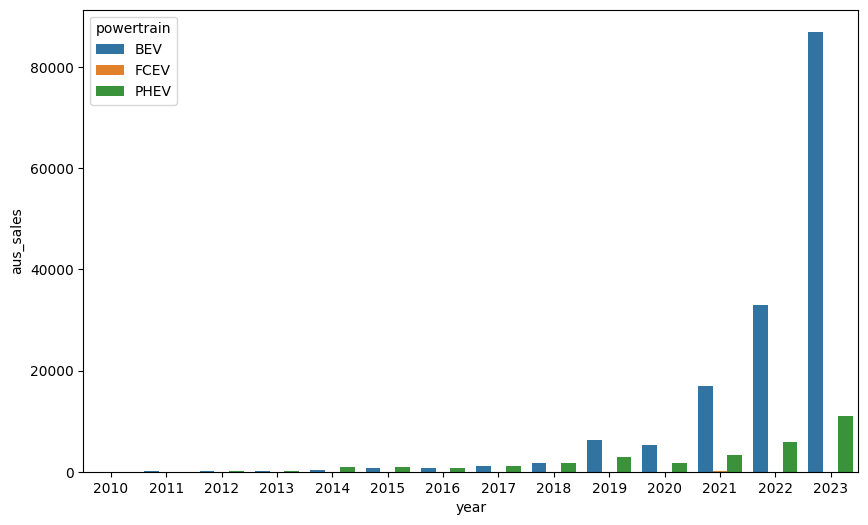

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(data=pd_type_sales_comp, x='year', y='aus_sales', hue='powertrain')
plt.show()


## Notes/insights

- Australia does seem to be behind the average EV car adoption rates (e.g. ev sales share is less than average)
    - however it seems to be following the same trends

### stuff that can be done


- combine all tables into one (outer join)
- add global cars sales dataset
    - see trend between ev car adoption/sales and fossil fuel cars

# Second Dataset - WIP

In [36]:
car_sales = spark.read.csv('../local_datasets/global_car_sales.csv', inferSchema=True, header=True)

#car_sales.where(col('Country')=='Albania').show()

car_sales.fillna('0').where(col('Country')=='Albania').show()

+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|Country|2005 Sales|2006 Sales|2007 Sales|2008 Sales|2009 Sales|2010 Sales|2011 Sales|2012 Sales|2013 Sales|2014 Sales|2015 Sales|2016 Sales|2017 Sales|2018 Sales|2019 Sales|2020 Sales|2021 Sales|2022 Sales|
+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|Albania|       800|       800|     1,600|     1,600|     1,000|     1,600|     2,100|     2,300|     2,300|     2,500|     2,500|     2,500|     1,370|     2,175|     3,005|         0|         0|         0|
+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----

In [37]:
car_sales = spark.read.csv('../local_datasets/global_car_sales.csv', inferSchema=True, header=True)
car_sales = car_sales.fillna('0')

def transform_df(row):
    years = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
    row_list = []

    for ind, i in enumerate(row[1:]):
        if i == '':
            sale = float(0)
        else:
            sale = float(i.replace(',',''))
        row_list.append( Row(region=row['Country'],year=years[ind], all_sales=sale ))

    return row_list 

schema = StructType([
    StructField("region", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("all_sales", DoubleType(), True)
])



cleaned_car_sales = car_sales.rdd

cleaned_car_sales = cleaned_car_sales.flatMap(lambda row : transform_df(row))
cleaned_car_sales = spark.createDataFrame(cleaned_car_sales, schema)

#cleaned_car_sales.collect()





In [38]:
cleaned_car_sales.show()

+------+----+-----------+
|region|year|  all_sales|
+------+----+-----------+
| China|2005|  3971101.0|
| China|2006|  5175961.0|
| China|2007|  6297538.0|
| China|2008|  6755609.0|
| China|2009|1.0331315E7|
| China|2010|1.3757794E7|
| China|2011|1.4472416E7|
| China|2012| 1.549524E7|
| China|2013| 1.792773E7|
| China|2014|1.9707677E7|
| China|2015|2.1210339E7|
| China|2016|2.4376902E7|
| China|2017|2.4718321E7|
| China|2018|2.3709782E7|
| China|2019|2.1472092E7|
| China|2020|2.0177731E7|
| China|2021|2.1481537E7|
| China|2022|2.3563287E7|
| India|2005|  1106863.0|
| India|2006|  1311373.0|
+------+----+-----------+
only showing top 20 rows



In [39]:
fossil_ev = all_ev_sales.join(cleaned_car_sales, ['region','year'])\
    .select('region','year', cleaned_car_sales.all_sales, all_ev_sales.sales)


schema = StructType([
    StructField("region", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("all_sales", IntegerType(), True),
    StructField("sales", IntegerType(), True)
])


def change_schema(row):
    return Row(region=row['region'],year=row['year'], all_sales=int(row['all_sales']), sales=int(row['sales']) )


fossil_ev = fossil_ev.rdd.map(lambda row : change_schema(row))


fossil_ev = spark.createDataFrame(fossil_ev, schema)
fossil_ev = fossil_ev.withColumn("fossil_sales", col("all_sales") - col("sales"))
fossil_ev = fossil_ev.withColumnRenamed('sales', 'ev_sales')


fossil_ev = fossil_ev.join(all_ev_sales_shares, ['region', 'year'])
fossil_ev = fossil_ev.withColumnRenamed('value', 'ev_share')
fossil_ev = fossil_ev.withColumn("fossil_share",100 - col("ev_share"))


# make sure data is not inaccurate (fossil fuel sales not negative, also = false share)
fossil_ev = fossil_ev.withColumn("fossil_sales", when(fossil_ev.fossil_sales < 0, float('nan')).otherwise(fossil_ev.fossil_sales))
fossil_ev = fossil_ev.withColumn("fossil_share", when(isnan(fossil_ev.fossil_sales), float('nan')).otherwise(fossil_ev.fossil_share).cast(DoubleType()))


fossil_ev.show()


+------+----+---------+--------+------------+-----------------+-----------------+
|region|year|all_sales|ev_sales|fossil_sales|         ev_share|     fossil_share|
+------+----+---------+--------+------------+-----------------+-----------------+
| China|2010| 13757794|    1440| 1.3756354E7|0.009999999776483|99.99000000022352|
| China|2011| 14472416|    5120| 1.4467296E7|0.034000001847744|99.96599999815226|
| China|2012| 15495240|    9860|  1.548538E7|0.072999998927116|99.92700000107288|
| China|2013| 17927730|   15730|    1.7912E7|0.094999998807907| 99.9050000011921|
| China|2014| 19707677|   73000| 1.9634677E7|0.400000005960465|99.59999999403954|
| China|2015| 21210339|  211000| 2.0999339E7|              1.0|             99.0|
| China|2016| 24376902|  339000| 2.4037902E7|              1.5|             98.5|
| China|2017| 24718321|  580000| 2.4138321E7| 2.40000009536743|97.59999990463257|
| China|2018| 23709782| 1090000| 2.2619782E7| 4.69999980926514|95.30000019073486|
| China|2019| 21

In [40]:
norway = fossil_ev.where(col('region')=='Norway')
australia = fossil_ev.where(col('region')=='Australia')

In [41]:
norway_df = norway.toPandas()
norway_df.to_csv('out.csv')

australia_df = australia.toPandas()


In [42]:
fossil_ev.toPandas().to_csv('all_out.csv')

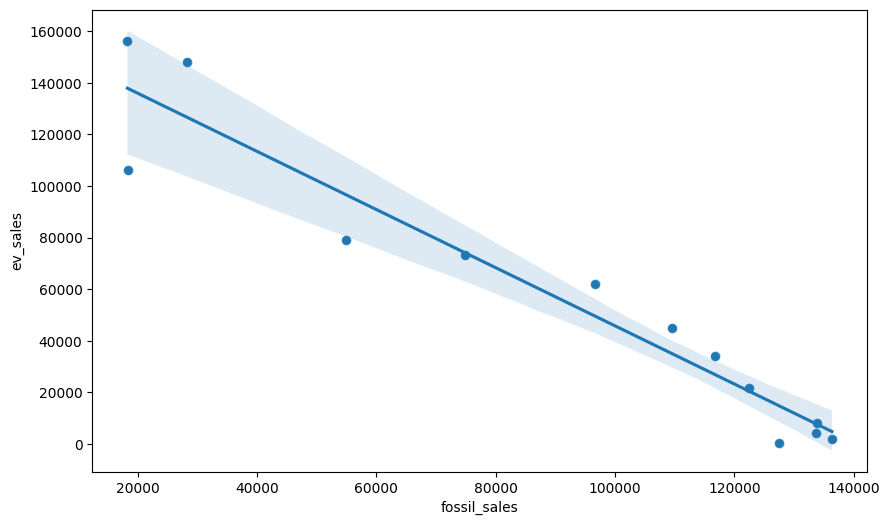

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fossil_sales', y='ev_sales', data=norway_df)
sns.regplot(x='fossil_sales', y='ev_sales', data=norway_df)

plt.show()


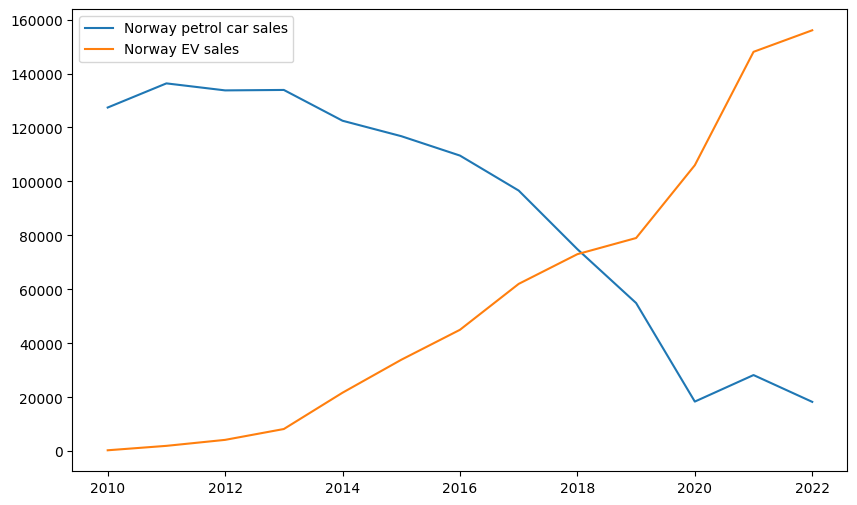

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(norway_df["year"], norway_df["fossil_sales"], label='Norway petrol car sales')
plt.plot(norway_df["year"], norway_df["ev_sales"], label='Norway EV sales')
plt.legend()

# Norway sells more electric cars compared to pretrol cars

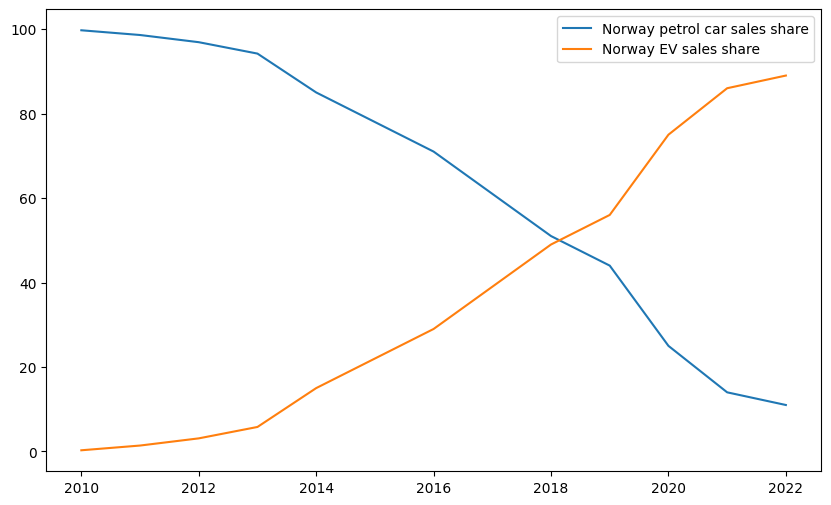

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(norway_df["year"], norway_df["fossil_share"], label='Norway petrol car sales share')
plt.plot(norway_df["year"], norway_df["ev_share"], label='Norway EV sales share')
plt.legend()

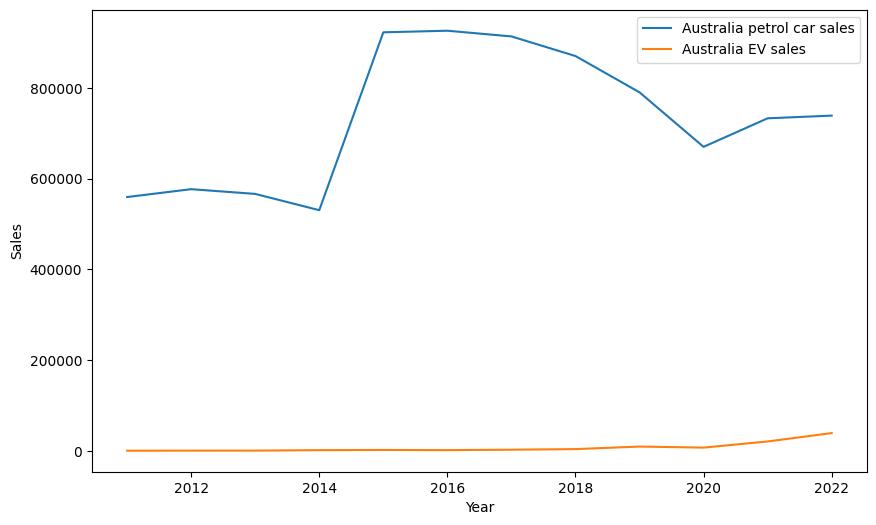

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(australia_df["year"], australia_df["fossil_sales"], label='Australia petrol car sales')
plt.plot(australia_df["year"], australia_df["ev_sales"], label='Australia EV sales')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()

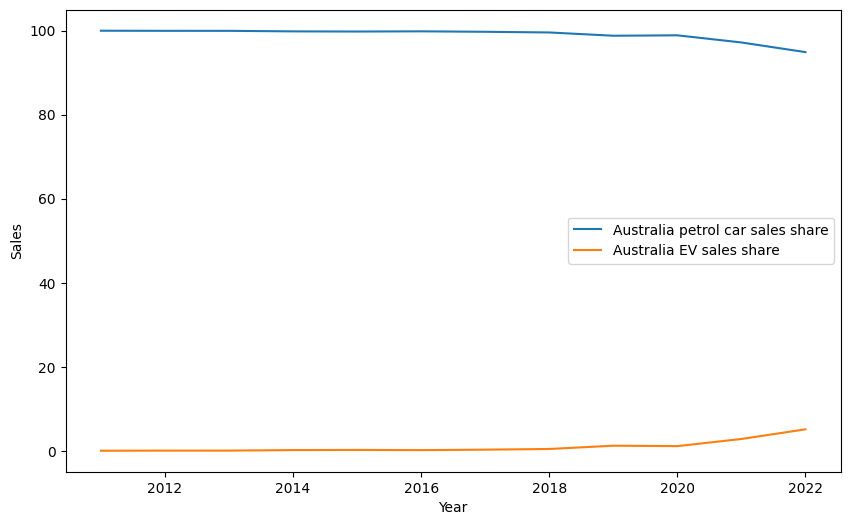

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(australia_df["year"], australia_df["fossil_share"], label='Australia petrol car sales share')
plt.plot(australia_df["year"], australia_df["ev_share"], label='Australia EV sales share')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()